<a href="https://colab.research.google.com/github/jazaineam1/Diplomado_ucentral_ME/blob/main/Lectura_12_Examples_clustering_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Ejemplos clustering***

## ***Universidad Central***



In [ ]:
## Librería utilizadas.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
##
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
##
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"


## ***¿Podemos detectar patrones entre consumidores específicos para identificar posibles fraudes?***

## ***Introducción.***




1. Suponga que hace parte del equipo de fraude de una compañía de seguros que tiene a cargo la emisión de polizas de seguro para varios tipos de reclamos tanto para individuos como para empresas. Se realiza un seguimiento de las pólizas que se emiten y se examina y evalúa cualquier reclamo presentado para determinar la legitimidad y la aprobación final para el pago por parte de la compañía de seguros. Sin embargo, muchas personas intentan aprovecharse presentando reclamos bajo falsos pretextos para obtener ingresos adicionales. El papel del equipo de fraude es determinar qué reclamos presentados deben aprobarse y cuáles deben denegarse.

2. Se le proporcionará un Dataset que contiene las reclamaciones recientes realizadas por 1000 personas. Los datos están sin etiquetar; es decir, no existe una variable que nos diga cuáles de estas afirmaciones son fraudulentas o no.

3. Su labor es responder a la siguiente pregunta: ***¿Existen patrones particulares en los grupos de reclamaciones presentadas que puedan ser indicativos de fraude?***



Buscaremos dar respuesta a la pregunta anterior mediante la siguiente estructura:

1. Realizar un análisis exploratorios de datos ***(EDA)*** para investigar visualmente la estructura de los datos.
2. Usar lo hallado en el numeral anterior como una primera guía en busca de establecer la viabilidad intuitiva del clustering.

3. Discutir las ventajas y limitaciones de los métodos típicos de agrupamiento; y finalmente.

4. Segmentar y generar conclusiones sobre clusters particulares.

## ***Exploración de los datos.***

In [ ]:
# Importamos el Dataset.
df_data = pd.read_excel(url_base + "insurance_data_clustering.xlsx", index_col = 0)
df_data.head()

,income,age,sex,approval,fraud,claims
case_id,,,,,,
59982,35750.95,42,M,Approved,Under Review,9518.95
87249,24078.27,19,M,Denied,No,19354.23
50406,39241.52,37,M,Denied,Fraud,13056.04
59391,33248.31,26,M,Approved,No,19238.37
96622,38649.96,54,M,Approved,No,14427.42


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 59982 to 97965
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   income    1000 non-null   float64
 1   age       1000 non-null   int64  
 2   sex       1000 non-null   object 
 3   approval  1000 non-null   object 
 4   fraud     1000 non-null   object 
 5   claims    1000 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 54.7+ KB


Contamos con 6 features:

- `income`: Ingreso del reclamante.
- `age`: Edad del reclamente.
- `sex`: Género del reclamente.
- `approval`: Decisión frente a la reclamación.
- `fraud`: Tres estados de la solicitud.
- `claims`: Cantidad reclamada.

In [ ]:
for column in df_data.select_dtypes(include = ["O"]):
  print("Las categorías para la feature:",column, "son", df_data[column].unique())

Las categorías para la feature: sex son ['M' 'F']
Las categorías para la feature: approval son ['Approved' 'Denied']
Las categorías para la feature: fraud son ['Under Review' 'No' 'Fraud']


Recordemos que una restricción para el algoritmo de clustering es que las features sean numéricas.

In [ ]:
# Consideremos solo las variables numéricas.
df = df_data[["income", "age", "claims"]]
df.head(5)

,income,age,claims
case_id,,,
59982,35750.95,42,9518.95
87249,24078.27,19,19354.23
50406,39241.52,37,13056.04
59391,33248.31,26,19238.37
96622,38649.96,54,14427.42


A continuación, veamos la información correspondiente a los reclamos bajo revisión (_under review_) y cómo se distribuyen:

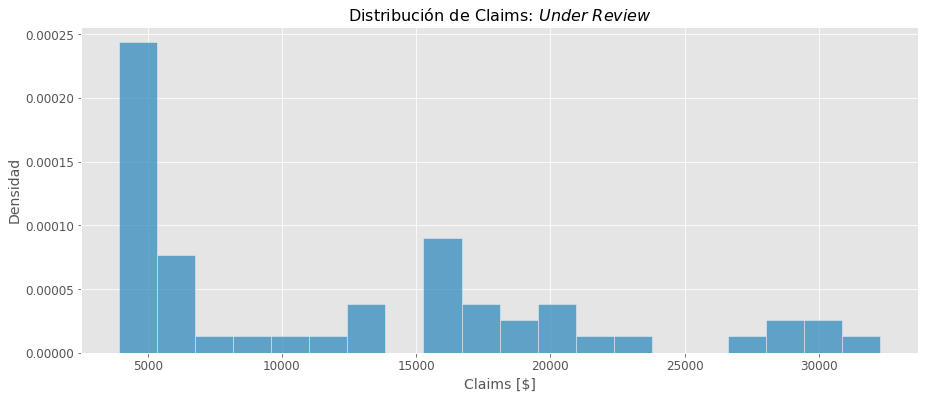

In [ ]:
## Casos en revisión.
df_frauds = df_data[df_data["fraud"] == "Under Review"]
##
sns.histplot(data = df_frauds, bins = 20, x = "claims", stat = "density")
plt.title("Distribución de Claims: $Under\ Review$", fontsize=16)
plt.xlabel("Claims [$]", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("Densidad", fontsize=14)
plt.yticks(fontsize=12)
plt.show()

***Notemos que la distribución es bastante extraña. Parece que tenemos tres grupos en la distribución de la reclamación.***



Veamos algunos scatterplots buscando obtener más información del comportamiento en el Dataset. Enfrentemos las siguientes features:

- `claims` vs. `income`
- `income` vs. `age`



#### ***Ejercicio 1.***

Realice los scatterplots solicitados. Además, estratifique los plots que acaba de realizar por género.

In [ ]:
## Celda de código para probar.

In [ ]:
## Celda de código para probar.

#### ***Ejercicio 2.***

¿Qué patrones se observan en los plots anteriores? ¿Por qué cree que esto podría estar sucediendo?

***Respuesta.***

Comente acá su respuesta.

## ***$k$-means clustering.***

En los plots anteriores parece que existen distintas poblaciones de individuos en función de las relaciones entre `claims` e `income` e `income` y `age`. Pensemos que podemos tener muchas `features` luego este procedimiento visual sería muy tedioso y podria llevar mucho tiempo.

Vamos a hacer uso de $K$-means para buscar reafirmar lo inspeccionado visualmente. Recordemos que este algoritmo separa el Dataset dado en $k$ clusters.

#### ***Ejercicio 3.***

$K$-means se basa en minimizar la distancia euclidiana entre los puntos de datos. ¿Qué tipo de problemas podría plantear esto en términos de los resultados que obtenemos? ¿Cómo podemos arreglar esto?

***Respuesta.***

Acá su respuesta...

Hay muchas formas de escalar, o **normalizar**, las features, una de las cuales hemos mencionado anteriormente. La mejor opción de normalización depende de los detalles particulares del Dataset.

De manera similar, la distancia euclidiana es la métrica más utilizada para calcular los clústeres, ya que es bastante fácil de calcular y funciona bien en la mayoría de los conjuntos de datos, pero no es la única. Es posible usar variaciones en la métrica de distancia según el Dataset que se está investigando. Por lo tanto, es un parámetro que debe ser considerado y explorado durante la etapa de EDA para determinar qué es lo mejor para proceder.

#### ***Ejercicio 4.***

Explore la herramienta [skleanr.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) y normalice vía esta técnica las fetures `age`, `income` y `claims` de acuerdo con los valores mínimo y máximo de cada feature. Como ilustración, si tenemos la feature `age`, entonces un valor normalizado para una edad $A$ se calcularía como:

$$\displaystyle\frac {X - min(age)} {max(age) - min(age)}$$

Esto se conoce como el ***método min-max scaling.***

***Guarde la información escalada en un pd.DataFrame llamado `df_norm`.***

***Respuesta.***

In [ ]:
## Celda de código para probar.

In [ ]:
## df_norm.describe().T

#### ***Ejercicio 5.***

Realize un scatterplot con la información escalada.

In [ ]:
## Celda de código para probar.

Los métodos que se muestran arriba transformarán los datos de tal manera que la magnitud de todas las características sea aproximadamente similar. Sin embargo, puede haber un método de escalado diferente que permita que la agrupación en clústeres $K$-means funcione mejor. La mejor elección del método de escalado depende de los datos específicos proporcionados.

#### ***Ejercicio 6.***

Imagine una situación en la que, además de nuestro Dataset original, hubiera algunas personas con altos ingresos que también presentaran reclamos de alto valor. ¿Qué podría salir mal con nuestro método de escalado anterior? ¿Cómo podría solucionar esto?

***Respuesta.***

Acá su respuesta...


## ***Selecionar el valor óptimo de $k$.***

Con base en los datos normalizados, podemos hacer una suposición "educada" de que tenemos $x$ grupos:

1. altos ingresos y bajos reclamos.
2. ingresos moderados y reclamos moderados.
3. ingresos moderados y reclamos elevados.
4. bajos ingresos y altos reclamos.

Aunque el análisis visual sugiere que $k = x$ es el valor óptimo, recuerde que tenemos rutinas para buscar verificar esto de manera cuantitativa, tenga en cuenta que hay múltiples Datasets que no pueden visualizarse fácilmente.

#### ***Ejercicio 7.***

Determine si la cantidad de $k=4$ o $k=3$ tiene alguna "evidencia" de ser la cantidad adecuada de clusters para este caso.

In [ ]:
## Celda de código para probar.

A partir del gráfico, la disminución de $XXXXX$ no es tan notoría desde $k=x$, por lo que podemos decir que la suposición original fue "XXXXX" (es bastante común que nuestra suposición visual y el resultado del método anterior sean ligeramente diferentes). Recuerde, este método funciona en múltiples dimensiones, por lo que, si bien la agrupación puede ser obvia en una dimensión, puede desaparecer cuando se combina con más variables.

## ***Implementando $k$-means.***

#### ***Ejercicio 8.***

Realice la implementación de $k$-means con $k$ igual al valor que encontró en el ejercicio anterior y sobre el dataframe `df_norm`. Seguido genere un scatterplot de `income` vs. `claims` donde el tono es proporcionado por el cluster que asignó el algoritmo.

In [ ]:
## Celda de código para probar.

In [ ]:
## Celda de código para probar.

#### ***Ejercicio 9.***

Dados los $x$ clusters de reclamos que se identificaron basados en `income` vs `claims` y teniendo en cuenta la información de `income` vs `age`, realice una sugerencia sobre lo que el departamento debe hacer con cada grupo.

***Respuesta.***

_Aca su respuesta...._

#### ***Ejercicio 10.***

¿Cuáles son algunos de los posibles inconvenientes cuando se aplica $k$-means a un Dataset?

***Respuesta.***

Hay algunas deficiencias potenciales (estos son ejemplos, obviamente hay otras respuestas posibles):

_Acá su respuesta..._

## ***Conclusiones.***

Logramos dividir con presunto éxito el Dataset en $x$ clusters, lo que validó nuestra intuición haciendo uso de $K$-means clustering. Una vez que se han identificado los clusters individuales, la compañía de seguros ahora puede determinar qué reclamos investigar más a fondo o considerar inmediatamente como fraudulentos en función de algunos criterios adicionales.